In [1]:
from pfd_toolkit import load_reports, LLM, Screener, Extractor
from pydantic import BaseModel, Field

In [2]:
reports = load_reports(end_date="2025-11-30",
                       refresh=True)

print(f"In total, there were {len(reports)} PFD reports published between July 2013 and November 2025.")

In total, there were 6043 PFD reports published between July 2013 and November 2025.


In [3]:
from dotenv import load_dotenv
import os

# Load OpenAI API key from local environment
load_dotenv("api.env")
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialise LLM client
llm_client = LLM(api_key=openai_api_key, 
                 max_workers=30, 
                 model="gpt-4.1-mini",
                 seed=123, 
                 temperature=0, 
                 timeout=60)

In [4]:
# Set up Screener
search_query = "Road traffic deaths **only**."
screener = Screener(llm=llm_client, reports=reports)

road_traffic_reports = screener.screen_reports(search_query=search_query)

Sending requests to the LLM: 100%|██████████| 6043/6043 [02:00<00:00, 50.30it/s]


In [39]:
extractor = Extractor(reports=road_traffic_reports,
                      llm=llm_client)

286087 total tokens


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Report length distribution'}, xlabel='Tokens count', ylabel='Number of reports'>)

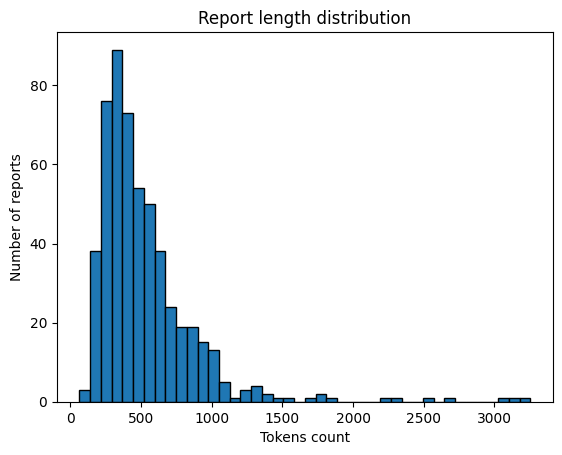

In [40]:
extractor.count(measure="tokens", as_="hist")

In [ ]:
extra_instructions = """
All reports are road traffic deaths. Discover sub-themes within this topic. 

Make sure themes are not overlapping; each must be wholly distinct.

Use British English.
"""


seed_topics = """
Poor eyesight; 
Failure to communicate or notify DVLA of something

If present, both of these must be distinct themes, not incorporated into a different theme.
"""

llm_client.model = "gpt-4.1"
extractor.llm=llm_client

IdentifiedThemes = extractor.discover_themes(extra_instructions=extra_instructions,
                                             seed_topics=seed_topics)

print(extractor.identified_themes)

```json
{
  "road_design": {
    "type": "bool",
    "description": "Issues relating to the design, layout, or geometry of roads, junctions, roundabouts, crossings, or other road infrastructure that contribute to collisions or create hazards for road users."
  },
  "signage_visibility": {
    "type": "bool",
    "description": "Problems with the presence, clarity, adequacy, or visibility of road signs, road markings, or signals, including missing, obscured, faded, or confusing signage."
  },
  "speed_limit": {
    "type": "bool",
    "description": "Concerns about the appropriateness, enforcement, or clarity of speed limits, including locations where the speed limit is considered too high or not adequately enforced for the road conditions."
  },
  "road_surface": {
    "type": "bool",
    "description": "Hazards arising from the condition of the road surface, such as potholes, subsidence, flooding, ice, debris, or inadequate drainage, which contribute to loss of control or collisions."

In [28]:
themed_reports = extractor.extract_features(
                              feature_model=IdentifiedThemes,
                              force_assign=True,
                              allow_multiple=True)

Extracting features: 100%|██████████| 539/539 [00:45<00:00, 11.87it/s]


In [29]:
themed_reports

,url,id,date,coroner,area,receiver,investigation,circumstances,concerns,vehicle_technology,...,elderly_driver_risk,medical_fitness,poor_eyesight,failure_notify_dvla,infrastructure_maintenance,weather_conditions,smart_motorways,public_transport_safety,mobility_scooter_safety,e_scooter_safety
0,https://www.judiciary.uk/prevention-of-future-...,2025-0592,2025-11-20,R. Travers,Surrey,Toyota (GB) PLC; Toyota Motor Corporation; Toy...,I commenced an investigation into the death of...,"On the morning of 11 January 2022, Lisa Bowen ...","Concern 1 As stated above, the brakes on the D...",True,...,False,False,False,False,False,False,False,False,False,False
11,https://www.judiciary.uk/prevention-of-future-...,2025-0572,2025-11-12,A. Hodson,Birmingham and Solihull,Secretary of State for Transport; DVLA; The Ge...,On 21 April 2022 I commenced an investigation ...,Chris was a front seat passenger in a Mazda au...,1. I heard evidence in this inquest concerning...,False,...,False,True,False,True,False,False,False,False,False,False
23,https://www.judiciary.uk/prevention-of-future-...,2025-0568,2025-11-06,G. Davies,Cornwall and the Isles of Scilly,Service Director for Environment Cornwall Council,"On 16 December 2024, I commenced an investigat...",Mr Vass was a Royal Navy serviceman based at R...,The concern is the absence of speed enforcemen...,False,...,False,False,False,False,False,False,False,False,False,False
46,https://www.judiciary.uk/prevention-of-future-...,2025-0539,2025-10-24,A. Gruffydd,Other,South Wales Police Chief Constable Jeremy Vaug...,On the 13 December 2022 I commenced an investi...,The deceased was Alexander Rhys Lewis and he w...,1. There was no opportunity for the pursuing d...,False,...,False,False,False,False,False,False,False,False,False,False
63,https://www.judiciary.uk/prevention-of-future-...,2025-0523,2025-10-16,R. Cohen,Cumbria,The Secretary of State for Transport,On 17 February 2023 I commenced an investigati...,Each of these three deaths occurred when a dri...,(1) The DVLA witnesses confirmed to me that th...,False,...,False,True,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6019,https://www.judiciary.uk/prevention-of-future-...,2013-0189,2013-08-16,J. Gittins,North Wales (East and Central),The Association of British Insurers; DVLA; VOSA,On 24 July 2012 I commenced an investigation i...,On 22 July 2012 Sadie was a rear seat passenge...,(1) Evidence was given by [REDACTED] Advanced ...,True,...,False,False,False,False,False,False,False,False,False,False
6022,https://www.judiciary.uk/prevention-of-future-...,2013-0170,2013-08-13,M. Rose,Somerset,The County Surveyor; Somerset County Council,"On 13 November 2023, I commenced an investigat...",The deceased was a front seat passenger of a L...,That I have between one and two deaths per yea...,False,...,False,False,False,False,False,False,False,False,False,False
6026,https://www.judiciary.uk/prevention-of-future-...,2013-0180,2013-08-07,D. Roberts,Cumbria,"Cumbria County Council, Highways and Transport...",On 2 September 2012 I commenced an investigati...,On 2 September 2012 the deceased was riding hi...,There is no barrier or restriction at the end ...,False,...,False,False,False,False,False,False,False,False,False,False
6029,https://www.judiciary.uk/prevention-of-future-...,2013-0194,2013-08-05,J. Taylor,London North,Traffic and Highway Network Management Departm...,At the inquest touching the death of Joseph Bu...,"At 7:15 pm on Saturday 28 July 2012, Mr. Burre...",A pedestrian on the central reservation has no...,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
extractor.tabulate()

,Category,Count,Percentage
0,road_design,280,51.948052
1,signage_visibility,135,25.046382
2,speed_limit,113,20.964750
3,road_surface,78,14.471243
4,pedestrian_safety,156,28.942486
5,cyclist_safety,54,10.018553
6,vehicle_maintenance,27,5.009276
7,vehicle_design,56,10.389610
8,driver_behaviour,154,28.571429
9,young_driver_risk,32,5.936920


In [35]:
from typing import Literal

# Create metadata
class Metadata(BaseModel):
    age: int = Field(description="The age of the deceased, if stated.")
    sex: str = Field(description="The sex of the deceased. You may infer sex from pronouns (e.g. 'He', 'Her', etc.) or the deceased's name, if not stated.")
    pedestrian: Literal["Pedestrian", "Driver", "Cyclist", "Other", "Not known"] = Field(
        description="Traffic role of the *deceased*: Pedestrian, Driver, Cyclist, Other or Not known.")

In [36]:
tagged_reports = extractor.extract_features(
        feature_model=Metadata,
        allow_multiple=True, 
        force_assign=False
)

Extracting features: 100%|██████████| 539/539 [00:21<00:00, 24.95it/s]


In [37]:
tagged_reports

,url,id,date,coroner,area,receiver,investigation,circumstances,concerns,vehicle_technology,...,failure_notify_dvla,infrastructure_maintenance,weather_conditions,smart_motorways,public_transport_safety,mobility_scooter_safety,e_scooter_safety,age,sex,pedestrian
0,https://www.judiciary.uk/prevention-of-future-...,2025-0592,2025-11-20,R. Travers,Surrey,Toyota (GB) PLC; Toyota Motor Corporation; Toy...,I commenced an investigation into the death of...,"On the morning of 11 January 2022, Lisa Bowen ...","Concern 1 As stated above, the brakes on the D...",True,...,False,False,False,False,False,False,False,<NA>,Female,Driver
11,https://www.judiciary.uk/prevention-of-future-...,2025-0572,2025-11-12,A. Hodson,Birmingham and Solihull,Secretary of State for Transport; DVLA; The Ge...,On 21 April 2022 I commenced an investigation ...,Chris was a front seat passenger in a Mazda au...,1. I heard evidence in this inquest concerning...,False,...,True,False,False,False,False,False,False,<NA>,Male,Other
23,https://www.judiciary.uk/prevention-of-future-...,2025-0568,2025-11-06,G. Davies,Cornwall and the Isles of Scilly,Service Director for Environment Cornwall Council,"On 16 December 2024, I commenced an investigat...",Mr Vass was a Royal Navy serviceman based at R...,The concern is the absence of speed enforcemen...,False,...,False,False,False,False,False,False,False,22,Male,Driver
46,https://www.judiciary.uk/prevention-of-future-...,2025-0539,2025-10-24,A. Gruffydd,Other,South Wales Police Chief Constable Jeremy Vaug...,On the 13 December 2022 I commenced an investi...,The deceased was Alexander Rhys Lewis and he w...,1. There was no opportunity for the pursuing d...,False,...,False,False,False,False,False,False,False,<NA>,Male,Other
63,https://www.judiciary.uk/prevention-of-future-...,2025-0523,2025-10-16,R. Cohen,Cumbria,The Secretary of State for Transport,On 17 February 2023 I commenced an investigati...,Each of these three deaths occurred when a dri...,(1) The DVLA witnesses confirmed to me that th...,False,...,True,False,False,False,False,False,False,70,Male,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6019,https://www.judiciary.uk/prevention-of-future-...,2013-0189,2013-08-16,J. Gittins,North Wales (East and Central),The Association of British Insurers; DVLA; VOSA,On 24 July 2012 I commenced an investigation i...,On 22 July 2012 Sadie was a rear seat passenge...,(1) Evidence was given by [REDACTED] Advanced ...,True,...,False,False,False,False,False,False,False,6,Female,Other
6022,https://www.judiciary.uk/prevention-of-future-...,2013-0170,2013-08-13,M. Rose,Somerset,The County Surveyor; Somerset County Council,"On 13 November 2023, I commenced an investigat...",The deceased was a front seat passenger of a L...,That I have between one and two deaths per yea...,False,...,False,False,False,False,False,False,False,30,Male,Other
6026,https://www.judiciary.uk/prevention-of-future-...,2013-0180,2013-08-07,D. Roberts,Cumbria,"Cumbria County Council, Highways and Transport...",On 2 September 2012 I commenced an investigati...,On 2 September 2012 the deceased was riding hi...,There is no barrier or restriction at the end ...,False,...,False,False,False,False,False,False,False,<NA>,Male,Cyclist
6029,https://www.judiciary.uk/prevention-of-future-...,2013-0194,2013-08-05,J. Taylor,London North,Traffic and Highway Network Management Departm...,At the inquest touching the death of Joseph Bu...,"At 7:15 pm on Saturday 28 July 2012, Mr. Burre...",A pedestrian on the central reservation has no...,False,...,False,False,False,False,False,False,False,<NA>,Male,Pedestrian


In [38]:
# Save to csv

tagged_reports.to_csv('../data/road_traffic.csv')